In [12]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
# from cnmf import cNMF, save_df_to_npz, load_df_from_npz
# import harmonypy
# from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context

### UMAP Visualization

Dataset with percent.mt >= 10

#### Importing from H5ad (issues)

In [13]:
# postTrans_rev = sc.read_h5ad("./Data/h5ad/postTransCD34.h5ad")

In [14]:
# print(postTrans_rev.obs.columns)

#### Importing from Seurat Coords

In [15]:
umap_coords = pd.read_csv("postTrans_coordinates.csv", index_col = 0)

In [16]:
print(umap_coords.head())

                            umap_1    umap_2  cluster
A_AAACGCTTCACTTGTT_A_pos -3.854382 -8.391539        4
A_AAAGGATCAATGCAGG_A_pos  4.369910  0.575330        9
A_AAAGGATGTGCGAGTA_A_pos -2.621185 -7.562319        4
A_AAAGGATTCACTGATG_A_pos  3.144841  0.364132        2
A_AAAGGGCCACCCTCTA_A_pos -6.825977 -1.130658        7


#### Plotting UMAP 

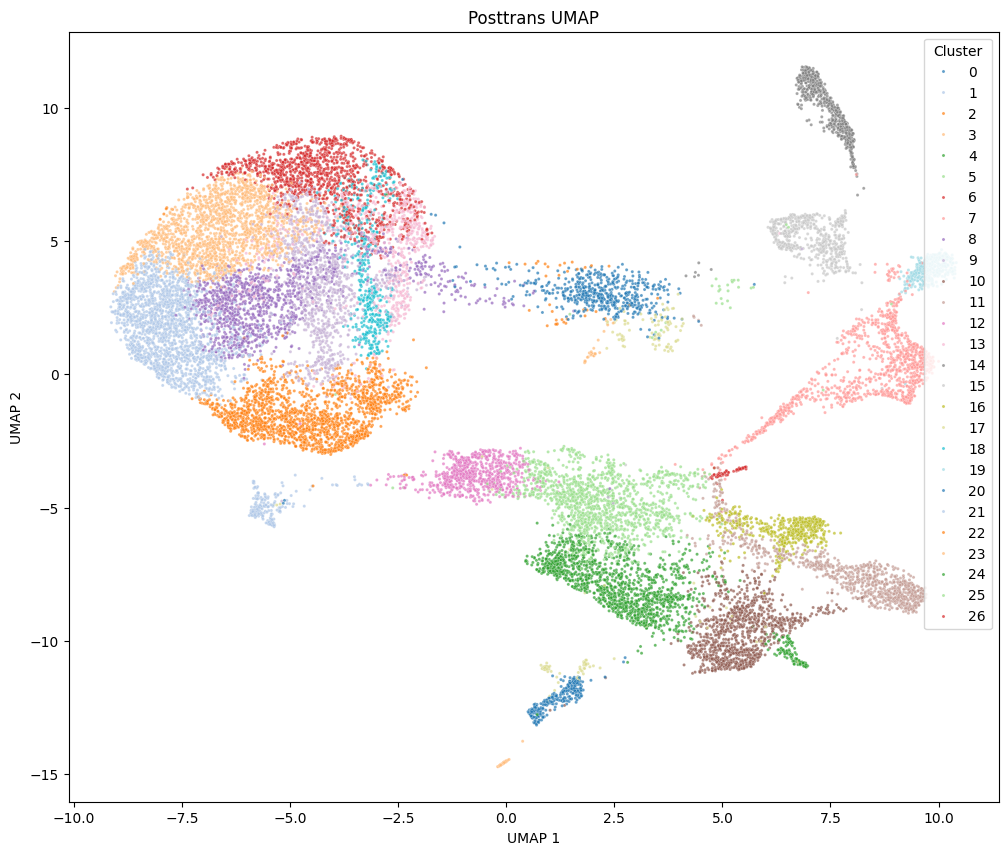

In [17]:
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x=-umap_coords.iloc[:, 0], 
    y=umap_coords.iloc[:, 1], 
    hue=umap_coords["cluster"], 
    palette="tab20", 
    s=5, alpha=0.7
)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Posttrans UMAP")
plt.legend(title = "Cluster")
plt.show()

### UMAP with top 5% usage for each interest GEP

Interesting GEPs
- GEP1 – Monocyte Lineage
- GEP4 – Elderly-biased HSC
- GEP6 – Late-Erythroid Lineage
- GEP14 – Basophil/Mast Cell Lineage
- GEP25 – Dendritic Cell Lineage
- GEP26 – Lymphoid Lineage
- GEP28 – Fetal-biased HSC
- GEP30 – Granulocyte Lineage
- GEP32 – Erythroid Lineage

*taken from cols*

Import starCAT usage scores

In [18]:
starCAT_usage = pd.read_csv("postTrans_common_starCAT.rf_usage_normalized.txt", sep = "\t", index_col = 0, header = 0)

starCAT_usage

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
A_AAACGCTTCACTTGTT_A_pos,0.096365,0.002613,8.605377e-07,0.070520,2.871097e-07,1.078125e-05,2.331253e-05,1.559450e-02,2.359533e-05,4.017984e-05,...,0.041604,0.000236,5.137467e-03,5.173710e-03,0.165957,0.014479,0.000841,0.176352,0.005821,0.000949
A_AAAGGATCAATGCAGG_A_pos,0.000021,0.024265,2.181186e-03,0.104772,5.378194e-03,1.200896e-05,5.789245e-07,8.755051e-03,8.175324e-06,1.677726e-05,...,0.007244,0.003605,4.288016e-04,1.164163e-04,0.001861,0.023281,0.086112,0.157487,0.000626,0.020397
A_AAAGGATGTGCGAGTA_A_pos,0.053085,0.046298,2.078237e-06,0.095898,4.761918e-04,1.177121e-08,1.575985e-05,1.432574e-02,4.829872e-04,1.403317e-04,...,0.014669,0.026157,2.396122e-02,4.344344e-06,0.212020,0.019041,0.000478,0.002940,0.000986,0.000003
A_AAAGGATTCACTGATG_A_pos,0.005681,0.007547,2.588857e-06,0.161387,6.282118e-04,1.087483e-03,7.092534e-09,2.504033e-03,3.549064e-06,4.994902e-07,...,0.014596,0.011377,4.792185e-09,4.134352e-05,0.000574,0.027411,0.094704,0.005742,0.000003,0.004366
A_AAAGGGCCACCCTCTA_A_pos,0.023277,0.009089,5.316663e-07,0.094579,1.904278e-15,5.007151e-07,7.054354e-03,8.511166e-05,6.357920e-04,4.912799e-05,...,0.314094,0.002334,5.609557e-03,2.838688e-08,0.000902,0.029065,0.000079,0.248209,0.003112,0.002387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F_TTTGTTGGTAGTGTGG_F_pos,0.000144,0.030579,9.394541e-08,0.138655,7.138249e-03,5.652477e-10,7.446775e-03,1.005055e-02,3.731937e-10,3.175398e-06,...,0.037760,0.054830,6.107168e-02,4.308184e-05,0.365254,0.018510,0.001573,0.005656,0.005504,0.000472
F_TTTGTTGGTCAAAGTA_F_pos,0.000021,0.008006,1.050721e-06,0.094437,1.836371e-03,2.429731e-03,4.184844e-03,6.074730e-03,1.300069e-05,9.184050e-06,...,0.001417,0.003737,3.877113e-06,4.226625e-06,0.003219,0.007113,0.283378,0.235401,0.003089,0.000057
F_TTTGTTGGTGCCTAAT_F_pos,0.000007,0.009088,1.030446e-06,0.162446,3.211939e-08,3.152855e-07,1.257601e-02,4.016187e-03,7.101746e-07,6.977844e-07,...,0.002679,0.001063,5.124840e-05,5.251531e-06,0.001064,0.024298,0.115156,0.350263,0.000221,0.000060
F_TTTGTTGTCCAAGGGA_F_pos,0.000082,0.013437,9.606605e-03,0.029832,5.672687e-03,1.420575e-03,1.516296e-03,2.102718e-07,3.896422e-05,3.421290e-06,...,0.011232,0.014704,1.121180e-02,5.693610e-05,0.001859,0.008174,0.251721,0.232056,0.004546,0.007395


Merging starCAT and coord datasets for UMAP

In [19]:
starCAT_coord = umap_coords.merge(starCAT_usage, left_index=True, right_index=True)

starCAT_coord

,umap_1,umap_2,cluster,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
A_AAACGCTTCACTTGTT_A_pos,-3.854382,-8.391539,4,0.096365,0.002613,8.605377e-07,0.070520,2.871097e-07,1.078125e-05,2.331253e-05,...,0.041604,0.000236,5.137467e-03,5.173710e-03,0.165957,0.014479,0.000841,0.176352,0.005821,0.000949
A_AAAGGATCAATGCAGG_A_pos,4.369910,0.575330,9,0.000021,0.024265,2.181186e-03,0.104772,5.378194e-03,1.200896e-05,5.789245e-07,...,0.007244,0.003605,4.288016e-04,1.164163e-04,0.001861,0.023281,0.086112,0.157487,0.000626,0.020397
A_AAAGGATGTGCGAGTA_A_pos,-2.621185,-7.562319,4,0.053085,0.046298,2.078237e-06,0.095898,4.761918e-04,1.177121e-08,1.575985e-05,...,0.014669,0.026157,2.396122e-02,4.344344e-06,0.212020,0.019041,0.000478,0.002940,0.000986,0.000003
A_AAAGGATTCACTGATG_A_pos,3.144841,0.364132,2,0.005681,0.007547,2.588857e-06,0.161387,6.282118e-04,1.087483e-03,7.092534e-09,...,0.014596,0.011377,4.792185e-09,4.134352e-05,0.000574,0.027411,0.094704,0.005742,0.000003,0.004366
A_AAAGGGCCACCCTCTA_A_pos,-6.825977,-1.130658,7,0.023277,0.009089,5.316663e-07,0.094579,1.904278e-15,5.007151e-07,7.054354e-03,...,0.314094,0.002334,5.609557e-03,2.838688e-08,0.000902,0.029065,0.000079,0.248209,0.003112,0.002387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F_TTTGTTGGTAGTGTGG_F_pos,-1.361962,-7.178270,4,0.000144,0.030579,9.394541e-08,0.138655,7.138249e-03,5.652477e-10,7.446775e-03,...,0.037760,0.054830,6.107168e-02,4.308184e-05,0.365254,0.018510,0.001573,0.005656,0.005504,0.000472
F_TTTGTTGGTCAAAGTA_F_pos,5.726266,6.885948,3,0.000021,0.008006,1.050721e-06,0.094437,1.836371e-03,2.429731e-03,4.184844e-03,...,0.001417,0.003737,3.877113e-06,4.226625e-06,0.003219,0.007113,0.283378,0.235401,0.003089,0.000057
F_TTTGTTGGTGCCTAAT_F_pos,6.995316,4.525879,3,0.000007,0.009088,1.030446e-06,0.162446,3.211939e-08,3.152855e-07,1.257601e-02,...,0.002679,0.001063,5.124840e-05,5.251531e-06,0.001064,0.024298,0.115156,0.350263,0.000221,0.000060
F_TTTGTTGTCCAAGGGA_F_pos,4.922432,7.291944,6,0.000082,0.013437,9.606605e-03,0.029832,5.672687e-03,1.420575e-03,1.516296e-03,...,0.011232,0.014704,1.121180e-02,5.693610e-05,0.001859,0.008174,0.251721,0.232056,0.004546,0.007395


Testing GEP usage scores

In [20]:
geps = ["1", "4", "6", "14", "25", "26", "28", "30", "32"]

In [21]:
interest_geps = starCAT_coord[geps]

interest_geps

,1,4,6,14,25,26,28,30,32
A_AAACGCTTCACTTGTT_A_pos,0.096365,0.070520,1.078125e-05,8.343805e-06,2.586536e-03,0.041604,5.137467e-03,0.165957,0.000841
A_AAAGGATCAATGCAGG_A_pos,0.000021,0.104772,1.200896e-05,2.390902e-02,2.008717e-03,0.007244,4.288016e-04,0.001861,0.086112
A_AAAGGATGTGCGAGTA_A_pos,0.053085,0.095898,1.177121e-08,4.174422e-05,2.781375e-04,0.014669,2.396122e-02,0.212020,0.000478
A_AAAGGATTCACTGATG_A_pos,0.005681,0.161387,1.087483e-03,4.224797e-03,1.321559e-04,0.014596,4.792185e-09,0.000574,0.094704
A_AAAGGGCCACCCTCTA_A_pos,0.023277,0.094579,5.007151e-07,2.052831e-03,4.643337e-07,0.314094,5.609557e-03,0.000902,0.000079
...,...,...,...,...,...,...,...,...,...
F_TTTGTTGGTAGTGTGG_F_pos,0.000144,0.138655,5.652477e-10,1.466189e-05,4.186979e-03,0.037760,6.107168e-02,0.365254,0.001573
F_TTTGTTGGTCAAAGTA_F_pos,0.000021,0.094437,2.429731e-03,8.990378e-07,5.281724e-05,0.001417,3.877113e-06,0.003219,0.283378
F_TTTGTTGGTGCCTAAT_F_pos,0.000007,0.162446,3.152855e-07,8.348926e-07,7.728283e-04,0.002679,5.124840e-05,0.001064,0.115156
F_TTTGTTGTCCAAGGGA_F_pos,0.000082,0.029832,1.420575e-03,1.148118e-04,1.985629e-04,0.011232,1.121180e-02,0.001859,0.251721


Plotting GEP usage scores (raw and top 5%)

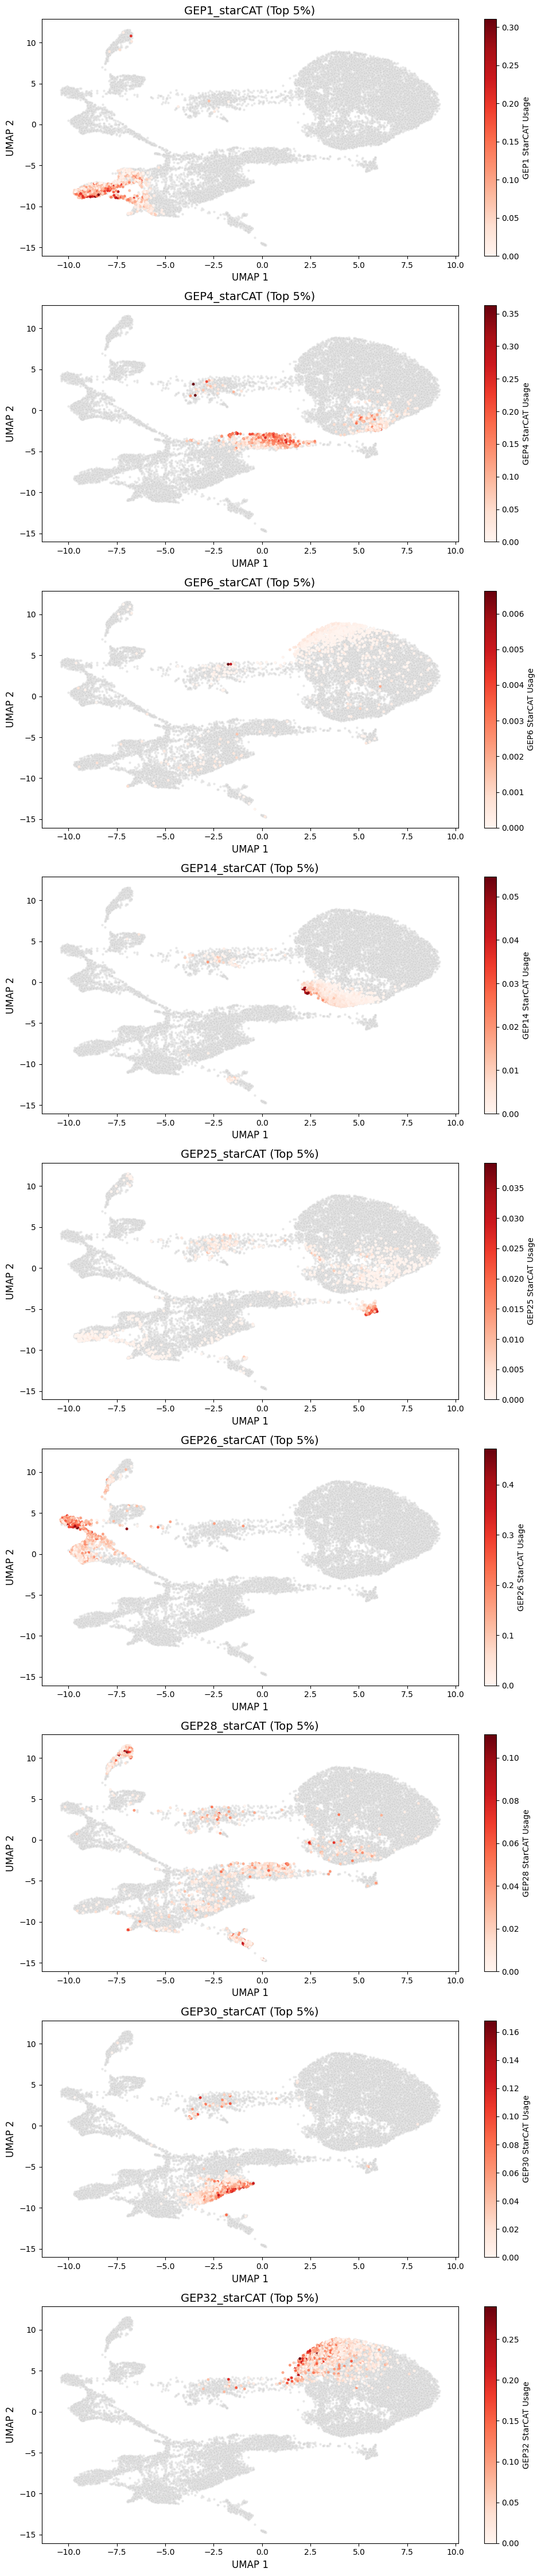

In [22]:
geps = ["1", "4", "6", "14", "25", "26", "28", "30", "32"]

fig, axes = plt.subplots(len(geps), 1, figsize=(10, len(geps) * 5))

for i, gep in enumerate(geps):
    percentile_95_starCAT = np.percentile(starCAT_coord[gep], 95)

    starCAT_coord[f"GEP{gep}_heat_starCAT"] = np.where(
        starCAT_coord[gep] >= percentile_95_starCAT, starCAT_coord[gep], np.nan
    )

    ax = axes[i]

    sns.scatterplot(
        data=starCAT_coord, x="umap_1", y="umap_2",
        color="lightgrey", alpha=0.5, s=10, ax=ax
    )

    scatter = sns.scatterplot(
        data=starCAT_coord, x="umap_1", y="umap_2",
        hue=f"GEP{gep}_heat_starCAT", palette="Reds",
        edgecolor=None, s=10, ax=ax, legend=False
    )

    norm = plt.Normalize(vmin=0, vmax=percentile_95_starCAT)
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(f"GEP{gep} StarCAT Usage")

    ax.set_title(f"GEP{gep}_starCAT (Top 5%)", fontsize=14)
    ax.set_xlabel("UMAP 1", fontsize=12)
    ax.set_ylabel("UMAP 2", fontsize=12)

plt.tight_layout()
plt.show()


Assistance with chatGPT and seurat documentation